In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration Variables
sampling_rate = 250
baseline_temp = 32
window_secs = 10
sensor_names = ["Bvp", "Eda_E4", "Resp", "Ecg", "Eda_RB", "Emg"]
num_repetitions = 8

# Paths 
raw_dir = Path("./dataset/PMED/PMHDB/raw-data")  # <-- Replace with your actual path
np_dir = Path("dataset","np-dataset")

# --- Helper Functions ---

def crossings_nonzero_neg2pos(data):
    npos = data < 0
    return (npos[:-1] & ~npos[1:]).nonzero()[0]

def to_categorical(y, num_classes=None, dtype="float32"):
    y = np.array(y, dtype="int")
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    return categorical

# --- Main Segmentation Function ---

def segment_pmhdb(df, baseline_shift=5):
    X, y_heater, y_covas = [], [], []
    stim = (df["Heater_cleaned"] != baseline_temp).astype("int")
    stim[stim == False] = -1
    stim_starts = crossings_nonzero_neg2pos(stim.values)
    
    window = int(window_secs * sampling_rate)
    num_baseline_windows = 0

    for start in stim_starts:
        baseline_start = start - (baseline_shift * sampling_rate)
        if (num_baseline_windows < num_repetitions
            and baseline_start > window
            and (df["Heater_cleaned"].values[baseline_start - window: baseline_start] == baseline_temp).all()):
            X.append(df[sensor_names].values[baseline_start - window: baseline_start])
            y_covas.append(0)
            y_heater.append(0)
            num_baseline_windows += 1

        start += 1
        temp = df["Heater_cleaned"].values[start]
        end = int(start + window)
        if (df["Heater_cleaned"].values[start: end] == temp).all():
            X.append(df[sensor_names].values[start: end])
            y_covas.append(sum(df["COVAS"].values[start: end]))
            y_heater.append(temp)

    temps = np.unique(y_heater)
    conversion = {x: i for i, x in enumerate(temps)}
    y_heater = np.vectorize(conversion.get)(y_heater)

    y_covas = np.array(y_covas)
    y_covas = y_covas / y_covas.max() * 100  # scale to 0-9
    y_covas = np.array([int(x // 25) + 1 if x > 0 else 0 for x in y_covas])
    y_covas[y_covas == 5] = 4

    return np.array(X), y_heater, y_covas

# --- Function to Process Raw CSV Files to .npy ---

def process_csv_files():
    if not raw_dir.exists():
        print(f"Directory '{raw_dir}' does not exist.")
        return

    file_names = list(raw_dir.glob("*.csv"))
    file_names.sort()

    data_list, heater_list, covas_list, subjects_list = [], [], [], []

    for index, filename in enumerate(tqdm(file_names)):
        subject_data = pd.read_csv(filename, sep=";", decimal=",")
        X, y_heater, y_covas = segment_pmhdb(subject_data)
        data_list.append(X)
        heater_list.append(y_heater)
        covas_list.append(y_covas)
        subjects_list.append([index] * X.shape[0])

    data = np.concatenate(data_list, axis=0)
    heater = np.concatenate(heater_list, axis=0)
    covas = np.concatenate(covas_list, axis=0)
    subjects = np.concatenate(subjects_list, axis=0)

    data = np.nan_to_num(data)
    data = data[..., np.newaxis]

    heater = to_categorical(heater)
    covas = to_categorical(covas)

    if not np_dir.exists():
        os.makedirs(np_dir)

    np.save(np_dir / "X.npy", data)
    np.save(np_dir / "y_heater.npy", heater)
    np.save(np_dir / "y_covas.npy", covas)
    np.save(np_dir / "subjects.npy", subjects)

    print("Preprocessing complete.")
    print("Data shape:", data.shape)
    print("Heater shape:", heater.shape)
    print("Covas shape:", covas.shape)
    print("Subjects shape:", subjects.shape)

process_csv_files()


100%|██████████| 52/52 [00:47<00:00,  1.09it/s]


Preprocessing complete.
Data shape: (2495, 2500, 6, 1)
Heater shape: (2495, 6)
Covas shape: (2495, 5)
Subjects shape: (2495,)


In [4]:
def process_csv_files_individually():
    if not raw_dir.exists():
        print(f"Directory '{raw_dir}' does not exist.")
        return

    file_names = list(raw_dir.glob("*.csv"))
    file_names.sort()

    if not np_dir.exists():
        os.makedirs(np_dir)

    for index, filename in enumerate(tqdm(file_names)):
        subject_data = pd.read_csv(filename, sep=";", decimal=",")
        X, y_heater, y_covas = segment_pmhdb(subject_data)

        X = np.nan_to_num(X)
        X = X[..., np.newaxis]
        y_heater_cat = to_categorical(y_heater)
        y_covas_cat = to_categorical(y_covas)
        subjects = np.array([index] * X.shape[0])

        # Generate a base filename from original .csv file (without extension)
        base_filename = filename.stem

        # Save files individually
        np.save(np_dir / f"{base_filename}_X.npy", X)
        np.save(np_dir / f"{base_filename}_y_heater.npy", y_heater_cat)
        np.save(np_dir / f"{base_filename}_y_covas.npy", y_covas_cat)
        np.save(np_dir / f"{base_filename}_subjects.npy", subjects)

        print(f"Saved .npy files for: {base_filename}")

    print("Per-file preprocessing complete.")

# Call the function
process_csv_files_individually()


  2%|▏         | 1/52 [00:00<00:47,  1.08it/s]

Saved .npy files for: S_01-synchronised-data


  4%|▍         | 2/52 [00:01<00:49,  1.02it/s]

Saved .npy files for: S_02-synchronised-data


  6%|▌         | 3/52 [00:02<00:43,  1.12it/s]

Saved .npy files for: S_03-synchronised-data


  8%|▊         | 4/52 [00:03<00:43,  1.10it/s]

Saved .npy files for: S_04-synchronised-data


 10%|▉         | 5/52 [00:04<00:40,  1.15it/s]

Saved .npy files for: S_05-synchronised-data


 12%|█▏        | 6/52 [00:05<00:41,  1.12it/s]

Saved .npy files for: S_06-synchronised-data


 13%|█▎        | 7/52 [00:06<00:39,  1.14it/s]

Saved .npy files for: S_07-synchronised-data


 15%|█▌        | 8/52 [00:07<00:43,  1.02it/s]

Saved .npy files for: S_08-synchronised-data


 17%|█▋        | 9/52 [00:08<00:40,  1.06it/s]

Saved .npy files for: S_09-synchronised-data


 19%|█▉        | 10/52 [00:09<00:39,  1.07it/s]

Saved .npy files for: S_10-synchronised-data


 21%|██        | 11/52 [00:10<00:37,  1.09it/s]

Saved .npy files for: S_11-synchronised-data


 23%|██▎       | 12/52 [00:11<00:36,  1.08it/s]

Saved .npy files for: S_12-synchronised-data


 25%|██▌       | 13/52 [00:11<00:34,  1.12it/s]

Saved .npy files for: S_13-synchronised-data


 27%|██▋       | 14/52 [00:13<00:37,  1.00it/s]

Saved .npy files for: S_14-synchronised-data


 29%|██▉       | 15/52 [00:14<00:36,  1.03it/s]

Saved .npy files for: S_15-synchronised-data


 31%|███       | 16/52 [00:15<00:35,  1.02it/s]

Saved .npy files for: S_16-synchronised-data


 33%|███▎      | 17/52 [00:16<00:34,  1.01it/s]

Saved .npy files for: S_17-synchronised-data


 35%|███▍      | 18/52 [00:17<00:35,  1.06s/it]

Saved .npy files for: S_18-synchronised-data


 37%|███▋      | 19/52 [00:18<00:36,  1.10s/it]

Saved .npy files for: S_19-synchronised-data


 38%|███▊      | 20/52 [00:19<00:34,  1.09s/it]

Saved .npy files for: S_20-synchronised-data


 40%|████      | 21/52 [00:20<00:34,  1.12s/it]

Saved .npy files for: S_21-synchronised-data


 42%|████▏     | 22/52 [00:21<00:32,  1.07s/it]

Saved .npy files for: S_22-synchronised-data


 44%|████▍     | 23/52 [00:22<00:31,  1.09s/it]

Saved .npy files for: S_23-synchronised-data


 46%|████▌     | 24/52 [00:23<00:29,  1.06s/it]

Saved .npy files for: S_24-synchronised-data


 48%|████▊     | 25/52 [00:24<00:29,  1.10s/it]

Saved .npy files for: S_25-synchronised-data


 50%|█████     | 26/52 [00:26<00:28,  1.09s/it]

Saved .npy files for: S_26-synchronised-data


 52%|█████▏    | 27/52 [00:27<00:27,  1.09s/it]

Saved .npy files for: S_27-synchronised-data


 54%|█████▍    | 28/52 [00:28<00:26,  1.12s/it]

Saved .npy files for: S_28-synchronised-data


 56%|█████▌    | 29/52 [00:29<00:24,  1.06s/it]

Saved .npy files for: S_29-synchronised-data


 58%|█████▊    | 30/52 [00:30<00:24,  1.09s/it]

Saved .npy files for: S_30-synchronised-data


 60%|█████▉    | 31/52 [00:31<00:22,  1.05s/it]

Saved .npy files for: S_31-synchronised-data


 62%|██████▏   | 32/52 [00:32<00:21,  1.09s/it]

Saved .npy files for: S_32-synchronised-data


 63%|██████▎   | 33/52 [00:33<00:19,  1.05s/it]

Saved .npy files for: S_33-synchronised-data


 65%|██████▌   | 34/52 [00:34<00:19,  1.10s/it]

Saved .npy files for: S_34-synchronised-data


 67%|██████▋   | 35/52 [00:35<00:17,  1.04s/it]

Saved .npy files for: S_35-synchronised-data


 69%|██████▉   | 36/52 [00:36<00:16,  1.04s/it]

Saved .npy files for: S_36-synchronised-data


 71%|███████   | 37/52 [00:37<00:14,  1.01it/s]

Saved .npy files for: S_37-synchronised-data


 73%|███████▎  | 38/52 [00:38<00:14,  1.00s/it]

Saved .npy files for: S_38-synchronised-data


 75%|███████▌  | 39/52 [00:39<00:12,  1.03it/s]

Saved .npy files for: S_39-synchronised-data


 77%|███████▋  | 40/52 [00:40<00:12,  1.02s/it]

Saved .npy files for: S_40-synchronised-data


 79%|███████▉  | 41/52 [00:41<00:11,  1.02s/it]

Saved .npy files for: S_41-synchronised-data


 81%|████████  | 42/52 [00:42<00:10,  1.02s/it]

Saved .npy files for: S_42-synchronised-data


 83%|████████▎ | 43/52 [00:43<00:08,  1.02it/s]

Saved .npy files for: S_43-synchronised-data


 85%|████████▍ | 44/52 [00:44<00:08,  1.03s/it]

Saved .npy files for: S_44-synchronised-data


 87%|████████▋ | 45/52 [00:45<00:07,  1.02s/it]

Saved .npy files for: S_45-synchronised-data


 88%|████████▊ | 46/52 [00:46<00:06,  1.07s/it]

Saved .npy files for: S_46-synchronised-data


 90%|█████████ | 47/52 [00:47<00:05,  1.02s/it]

Saved .npy files for: S_47-synchronised-data


 92%|█████████▏| 48/52 [00:48<00:04,  1.07s/it]

Saved .npy files for: S_48-synchronised-data


 94%|█████████▍| 49/52 [00:49<00:03,  1.05s/it]

Saved .npy files for: S_49-synchronised-data


 96%|█████████▌| 50/52 [00:51<00:02,  1.10s/it]

Saved .npy files for: S_50-synchronised-data


 98%|█████████▊| 51/52 [00:52<00:01,  1.06s/it]

Saved .npy files for: S_51-synchronised-data


100%|██████████| 52/52 [00:53<00:00,  1.03s/it]

Saved .npy files for: S_52-synchronised-data
Per-file preprocessing complete.


In [12]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
import joblib
from tensorflow.keras.models import load_model

# ----------------------------------------------------------------------
# 1. Load Pre-Trained Models
# ----------------------------------------------------------------------
feature_selector = joblib.load('feature_selector_1.pkl')
dl_model = load_model('pain_model.h5')

# ----------------------------------------------------------------------
# 2. Feature Extraction Functions
# ----------------------------------------------------------------------
def extract_time_domain_features(sample):
    """Extract 20 time-domain features per channel (6 channels)."""
    features = []
    for channel_idx in range(sample.shape[1]):  # Loop through 6 channels
        channel = sample[:, channel_idx, 0]     # Shape: (2500,)
        channel_features = [
            np.mean(channel), np.std(channel), np.var(channel),
            np.min(channel), np.max(channel), np.ptp(channel),
            np.percentile(channel, 25), np.percentile(channel, 50),
            np.percentile(channel, 75), 
            skew(channel, nan_policy="omit"),
            kurtosis(channel, nan_policy="omit"),
            entropy(np.histogram(channel, bins=10)[0] + 1e-10),  # Avoid log(0)
            np.sum(channel), 
            np.sqrt(np.mean(channel ** 2)),
            np.mean(np.abs(channel)), 
            np.mean(np.diff(channel)),
            np.std(np.diff(channel)), 
            np.min(np.diff(channel)),
            np.max(np.diff(channel)), 
            np.mean(np.abs(np.diff(channel)))
        ]
        features.extend(channel_features)
    return np.array(features)

def extract_frequency_domain_features(sample, sample_rate=250):
    """Extract 7 frequency-domain features per channel (6 channels)."""
    features = []
    for channel_idx in range(sample.shape[1]):  # Loop through 6 channels
        channel = sample[:, channel_idx, 0]     # Shape: (2500,)
        N = len(channel)
        freqs = fftfreq(N, 1 / sample_rate)
        fft_values = np.abs(fft(channel))

        # Handle division by zero in spectral features
        total_power = np.sum(fft_values)
        if total_power == 0:
            spectral_centroid = 0
            spectral_spread = 0
        else:
            spectral_centroid = np.sum(freqs * fft_values) / total_power
            spectral_spread = np.sum((freqs ** 2) * fft_values) / total_power

        channel_features = [
            total_power, 
            np.mean(fft_values), 
            np.std(fft_values),
            np.max(fft_values), 
            freqs[np.argmax(fft_values)],
            spectral_centroid,
            spectral_spread
        ]
        features.extend(channel_features)
    return np.array(features)

def extract_features(data):
    """Combine time and frequency features (162 total per sample)."""
    if len(data.shape) == 3:
        data = data[np.newaxis, ...]  # Add batch dimension if needed

    all_features = []
    for sample in data:
        sample = sample.reshape(-1, 6, 1)  # Ensure shape (2500, 6, 1)
        time_features = extract_time_domain_features(sample)
        freq_features = extract_frequency_domain_features(sample)
        combined = np.hstack([time_features, freq_features])
        all_features.append(combined)

    return np.vstack(all_features)

# ----------------------------------------------------------------------
# 3. Load and Prepare New Data
# ----------------------------------------------------------------------
data_path = './dataset/np-dataset/S_49-synchronised-data_X.npy'
loaded_data = np.load(data_path)  # Shape: (N, 2500, 6, 1)

# ----------------------------------------------------------------------
# 4. Feature Extraction & Selection
# ----------------------------------------------------------------------
features = extract_features(loaded_data)                # Shape: (N, 162)
#selected_features = feature_selector.transform(features)  # Shape: (N, 100)
selected_features = features

# Load the scaler used in training
scaler = joblib.load("scaler.pkl")
selected_features = scaler.transform(selected_features)
# ----------------------------------------------------------------------
# 5. Predict Pain Levels (0-4)
# ----------------------------------------------------------------------
predictions = dl_model.predict(selected_features)
predicted_classes = np.argmax(predictions, axis=1)

# ----------------------------------------------------------------------
# 6. Output
# ----------------------------------------------------------------------
print("Predicted pain levels:", predicted_classes)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted pain levels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
import joblib
import pickle
from tensorflow.keras.models import load_model

# Pretty print settings
np.set_printoptions(precision=4, suppress=True, linewidth=150)

# ----------------------------------------------------------------------
# 1. Load Pre-Trained Models
# ----------------------------------------------------------------------
feature_selector = joblib.load('feature_selector_1.pkl')
print("\n[1] Feature selector loaded.")

dl_model = load_model('pain_model.h5')
print("[1] Deep learning model loaded.")

# ----------------------------------------------------------------------
# 2. Feature Extraction Functions
# ----------------------------------------------------------------------
def extract_time_domain_features(sample):
    features = []
    for channel_idx in range(sample.shape[1]):
        channel = sample[:, channel_idx, 0]
        channel_features = [
            np.mean(channel), np.std(channel), np.var(channel),
            np.min(channel), np.max(channel), np.ptp(channel),
            np.percentile(channel, 25), np.percentile(channel, 50),
            np.percentile(channel, 75), 
            skew(channel, nan_policy="omit"),
            kurtosis(channel, nan_policy="omit"),
            entropy(np.histogram(channel, bins=10)[0] + 1e-10),
            np.sum(channel), 
            np.sqrt(np.mean(channel ** 2)),
            np.mean(np.abs(channel)), 
            np.mean(np.diff(channel)),
            np.std(np.diff(channel)), 
            np.min(np.diff(channel)),
            np.max(np.diff(channel)), 
            np.mean(np.abs(np.diff(channel)))
        ]
        features.extend(channel_features)
    return np.array(features)

def extract_frequency_domain_features(sample, sample_rate=250):
    features = []
    for channel_idx in range(sample.shape[1]):
        channel = sample[:, channel_idx, 0]
        N = len(channel)
        freqs = fftfreq(N, 1 / sample_rate)
        fft_values = np.abs(fft(channel))

        total_power = np.sum(fft_values)
        if total_power == 0:
            spectral_centroid = 0
            spectral_spread = 0
        else:
            spectral_centroid = np.sum(freqs * fft_values) / total_power
            spectral_spread = np.sum((freqs ** 2) * fft_values) / total_power

        channel_features = [
            total_power, 
            np.mean(fft_values), 
            np.std(fft_values),
            np.max(fft_values), 
            freqs[np.argmax(fft_values)],
            spectral_centroid,
            spectral_spread
        ]
        features.extend(channel_features)
    return np.array(features)

def extract_features(data):
    if len(data.shape) == 3:
        data = data[np.newaxis, ...]  # Add batch dimension if needed

    all_features = []
    for idx, sample in enumerate(data):
        sample = sample.reshape(-1, 6, 1)
        time_features = extract_time_domain_features(sample)
        freq_features = extract_frequency_domain_features(sample)
        combined = np.hstack([time_features, freq_features])
        all_features.append(combined)
        print(f"\n[4] Sample {idx} - Time domain features (shape {time_features.shape}):\n", time_features)
        print(f"\n[4] Sample {idx} - Frequency domain features (shape {freq_features.shape}):\n", freq_features)
        print(f"\n[4] Sample {idx} - Combined features (shape {combined.shape}):\n", combined)

    return np.vstack(all_features)

# ----------------------------------------------------------------------
# 3. Load and Prepare New Data
# ----------------------------------------------------------------------
data_path = './dataset/np-dataset/S_01-synchronised-data_X.npy'
loaded_data = np.load(data_path)
print(f"\n[3] Loaded data shape: {loaded_data.shape}")
print(f"[3] First sample (shape {loaded_data[0].shape}):\n", loaded_data[0, :, :, 0])

# ----------------------------------------------------------------------
# 4. Feature Extraction & Selection
# ----------------------------------------------------------------------
features = extract_features(loaded_data)
print(f"\n[4] All features shape: {features.shape}")
print("[4] First sample features:\n", features[0])

# Optionally use feature selector
# selected_features = feature_selector.transform(features)
# print(f"\n[4] Selected features shape: {selected_features.shape}")
# print("[4] First selected feature sample:\n", selected_features[0])
selected_features = features
print("[4] Skipping feature selection; using all features.")

# ----------------------------------------------------------------------
# 5. Scaling Features
# ----------------------------------------------------------------------
with open("scaler.pkl", "rb") as f:  # open file in read-binary mode
    scaler = pickle.load(f) 
print("\n[5] Scaler loaded.")

selected_features = scaler.transform(selected_features)
print(f"[5] Scaled features shape: {selected_features.shape}")
print("[5] First scaled sample:\n", selected_features[0])

# ----------------------------------------------------------------------
# 6. Predict Pain Levels (0-4)
# ----------------------------------------------------------------------
predictions = dl_model.predict(selected_features)
print("\n[6] Raw model predictions (softmax output):\n", predictions)

predicted_classes = np.argmax(predictions, axis=1)
print("\n[6] Predicted class labels:\n", predicted_classes)

# ----------------------------------------------------------------------
# 7. Final Output
# ----------------------------------------------------------------------
print("\n[7] Predicted pain levels:", predicted_classes)



[1] Feature selector loaded.
[1] Deep learning model loaded.

[3] Loaded data shape: (48, 2500, 6, 1)
[3] First sample (shape (2500, 6, 1)):
 [[-34.6302   2.4165  -5.5862  -0.178   14.1293  -0.0011]
 [-35.6854   2.4163  -5.5954  -0.1646  14.1221   0.0008]
 [-36.7406   2.4161  -5.5649  -0.1303  14.1422  -0.0103]
 ...
 [-52.2755   3.1499  -2.2374   0.0577  14.3167  -0.0022]
 [-49.5842   3.1521  -2.3109   0.0801  14.3261   0.0058]
 [-46.8929   3.1542  -2.3026   0.0826  14.3284  -0.0074]]

[4] Sample 0 - Time domain features (shape (120,)):
 [   -0.6059    38.1286  1453.7896   -92.7736    59.3399   152.1135   -31.7698    10.4445    30.7116    -0.5587    -0.8177     2.1609 -1514.6594
    38.1334    32.6428    -0.0049     2.3738   -12.7956    28.8449     1.3788     2.9274     0.4167     0.1737     2.3951     3.8048     1.4097
     2.7141     2.8407     3.1056     0.7381    -0.3389     1.9566  7318.4175     2.9569     2.9274     0.0003     0.0021    -0.0029     0.0084
     0.0012     0.4623 

In [22]:
import numpy as np

# Load the X.npy file
X = np.load('labels.npy')

# Display basic info and contents
print("Shape of X:", X.shape)
print("Data type:", X.dtype)
print("Contents of X:\n", X)
print("\nFirst 5 rows of X:\n", X[:200])

Shape of X: (2495,)
Data type: int64
Contents of X:
 [0 0 0 ... 1 0 0]

First 5 rows of X:
 [0 0 0 0 0 0 1 0 1 0 1 0 1 0 3 0 0 0 2 2 0 0 1 0 2 0 1 0 1 0 0 1 1 1 1 3 4 1 2 3 0 3 4 2 1 0 3 0 1 0 2 0 4 0 4 0 3 0 0 0 2 0 0 0 1 2 1 0 1 4 1 2 1 2
 0 2 4 1 0 2 4 2 1 2 1 2 1 4 0 1 4 1 3 2 2 2 3 0 0 0 4 0 1 0 3 0 4 0 1 0 0 0 3 4 0 4 0 2 1 0 0 0 1 3 2 4 0 3 4 1 0 4 1 0 4 0 4 0 2 3 0 1 1 4 1 0 2 0
 0 0 2 0 1 0 4 0 0 0 1 0 0 1 4 3 0 0 1 1 2 4 1 0 4 0 1 1 2 0 0 0 0 0 1 0 1 2 0 1 1 1 0 1 2 0 4 0 3 0 0 0]


In [23]:
import numpy as np

# Load the labels.npy file
X = np.load('labels.npy')

# Display basic info
print("Shape of X:", X.shape)
print("Data type:", X.dtype)

# Display contents (use cautiously for large arrays)
print("Contents of X:\n", X)

# Display first 200 rows
print("\nFirst 200 rows of X:\n", X[:200])

# Count the number of each unique label
unique_labels, counts = np.unique(X, return_counts=True)
print("\nLabel counts:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")


Shape of X: (2495,)
Data type: int64
Contents of X:
 [0 0 0 ... 1 0 0]

First 200 rows of X:
 [0 0 0 0 0 0 1 0 1 0 1 0 1 0 3 0 0 0 2 2 0 0 1 0 2 0 1 0 1 0 0 1 1 1 1 3 4 1 2 3 0 3 4 2 1 0 3 0 1 0 2 0 4 0 4 0 3 0 0 0 2 0 0 0 1 2 1 0 1 4 1 2 1 2
 0 2 4 1 0 2 4 2 1 2 1 2 1 4 0 1 4 1 3 2 2 2 3 0 0 0 4 0 1 0 3 0 4 0 1 0 0 0 3 4 0 4 0 2 1 0 0 0 1 3 2 4 0 3 4 1 0 4 1 0 4 0 4 0 2 3 0 1 1 4 1 0 2 0
 0 0 2 0 1 0 4 0 0 0 1 0 0 1 4 3 0 0 1 1 2 4 1 0 4 0 1 1 2 0 0 0 0 0 1 0 1 2 0 1 1 1 0 1 2 0 4 0 3 0 0 0]

Label counts:
Label 0: 1041
Label 1: 628
Label 2: 308
Label 3: 266
Label 4: 252


In [5]:
import numpy as np

# Load the X.npy file
X = np.load('./dataset/np-dataset/S_01-synchronised-data_X.npy')

# Display basic info and contents
print("Shape of X:", X.shape)
print("Data type:", X.dtype)
print("Contents of X:\n", X)


Shape of X: (48, 2500, 6, 1)
Data type: float64
Contents of X:
 [[[[ 2.17645360e+01]
   [ 5.43176788e+00]
   [-2.57517497e+00]
   [-1.04110718e-01]
   [ 1.16984049e+01]
   [ 1.93786621e-03]]

  [[ 2.34431050e+01]
   [ 5.43157092e+00]
   [-2.56551107e+00]
   [-1.04812622e-01]
   [ 1.17015203e+01]
   [-7.84301758e-03]]

  [[ 2.83867600e+01]
   [ 5.43137397e+00]
   [-2.55584717e+00]
   [-1.05514526e-01]
   [ 1.17046356e+01]
   [-1.76239014e-02]]

  ...

  [[ 1.83699720e+01]
   [ 5.41246475e+00]
   [-1.99127197e+00]
   [-5.92346191e-02]
   [ 1.21532440e+01]
   [-1.00708008e-02]]

  [[ 1.76373280e+01]
   [ 5.41230472e+00]
   [-2.00958252e+00]
   [-5.41534424e-02]
   [ 1.21387482e+01]
   [-1.37329102e-03]]

  [[ 1.69046840e+01]
   [ 5.41214469e+00]
   [-1.94956462e+00]
   [-4.82330322e-02]
   [ 1.21444702e+01]
   [ 6.88171387e-03]]]


 [[[ 3.18874839e+01]
   [ 5.40886131e+00]
   [-1.82189941e+00]
   [ 2.11029053e-01]
   [ 1.19543076e+01]
   [ 1.70745850e-02]]

  [[ 3.23966200e+01]
   [ 5.408

In [18]:
import numpy as np

# Load the X.npy file
X = np.load('combined_features.npy')

# Display basic info and contents
print("Shape of X:", X.shape)
print("Data type:", X.dtype)
print("Contents of X:\n", X)


Shape of X: (2495, 162)
Data type: float64
Contents of X:
 [[  0.2933  24.2866 589.837  ...   0.      -0.       0.0751]
 [  0.5662  23.7076 562.0488 ...   0.      -0.0001   0.0784]
 [  0.1028  23.8391 568.3011 ...   0.      -0.0001   0.0769]
 ...
 [ -1.0924  18.611  346.3683 ...   0.2     -0.       0.0759]
 [ -0.0358  15.5507 241.824  ...   0.2     -0.0001   0.0765]
 [  0.3239  13.1249 172.2639 ...   0.2     -0.       0.0773]]


In [17]:
import numpy as np

# Load the X.npy file
X = np.load('./dataset/np-dataset/X.npy')

# Display basic info and contents
print("Shape of X:", X.shape)
print("Data type:", X.dtype)
print("Contents of X:\n", X)


Shape of X: (2495, 2500, 6, 1)
Data type: float64
Contents of X:
 [[[[ 21.7645]
   [  5.4318]
   [ -2.5752]
   [ -0.1041]
   [ 11.6984]
   [  0.0019]]

  [[ 23.4431]
   [  5.4316]
   [ -2.5655]
   [ -0.1048]
   [ 11.7015]
   [ -0.0078]]

  [[ 28.3868]
   [  5.4314]
   [ -2.5558]
   [ -0.1055]
   [ 11.7046]
   [ -0.0176]]

  ...

  [[ 18.37  ]
   [  5.4125]
   [ -1.9913]
   [ -0.0592]
   [ 12.1532]
   [ -0.0101]]

  [[ 17.6373]
   [  5.4123]
   [ -2.0096]
   [ -0.0542]
   [ 12.1387]
   [ -0.0014]]

  [[ 16.9047]
   [  5.4121]
   [ -1.9496]
   [ -0.0482]
   [ 12.1445]
   [  0.0069]]]


 [[[ 31.8875]
   [  5.4089]
   [ -1.8219]
   [  0.211 ]
   [ 11.9543]
   [  0.0171]]

  [[ 32.3966]
   [  5.4089]
   [ -1.7868]
   [  0.205 ]
   [ 11.9526]
   [  0.0062]]

  [[ 32.579 ]
   [  5.409 ]
   [ -1.7693]
   [  0.1932]
   [ 11.9507]
   [ -0.0244]]

  ...

  [[ 13.0243]
   [  5.338 ]
   [ -0.8919]
   [ -0.0602]
   [ 11.7275]
   [ -0.0075]]

  [[ 12.7377]
   [  5.3381]
   [ -0.9181]
   [ -0.0475]
  

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import skew, kurtosis, entropy
from scipy.fft import fft, fftfreq
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Load the dataset
X_features = np.load("./dataset/np-dataset/X.npy")
y_labels = np.load("./dataset/np-dataset/y_covas.npy")

# Check the shapes of the data
print(f"Original Shape of X_features: {X_features.shape}")
print(f"Original Shape of y_labels: {y_labels.shape}")

# Flatten y_labels for classification (one-vs-all)
if len(y_labels.shape) > 1:
    y_labels_flat = np.argmax(y_labels, axis=1)  # Convert one-hot encoding to class labels
else:
    y_labels_flat = y_labels

# Time-domain feature extraction
def extract_time_domain_features(data):
    feature_vector = []
    for sample in data:
        sample_features = []
        for channel in sample.T:  # Loop through each channel
            sample_features.extend([
                np.mean(channel),              # Mean
                np.std(channel),               # Standard Deviation
                np.var(channel),               # Variance
                np.min(channel),               # Minimum
                np.max(channel),               # Maximum
                np.ptp(channel),               # Peak-to-Peak Amplitude
                np.percentile(channel, 25),    # 25th Percentile
                np.percentile(channel, 50),    # Median
                np.percentile(channel, 75),    # 75th Percentile
                skew(channel, nan_policy="omit"),  # Skewness
                kurtosis(channel, nan_policy="omit"),  # Kurtosis
                entropy(np.histogram(channel, bins=10)[0] + 1),  # Entropy
                np.sum(channel),               # Sum
                np.sqrt(np.mean(channel ** 2)), # RMS
                np.mean(np.abs(channel)),      # Mean Absolute Value
                np.mean(np.diff(channel)),     # Mean of First Difference
                np.std(np.diff(channel)),      # Standard Deviation of First Difference
                np.min(np.diff(channel)),      # Minimum of First Difference
                np.max(np.diff(channel)),      # Maximum of First Difference
                np.mean(np.abs(np.diff(channel))),  # Mean Absolute Difference
            ])
        feature_vector.append(sample_features)
    return np.array(feature_vector)

# Frequency-domain feature extraction
def extract_frequency_domain_features(data, sample_rate=1.0):
    feature_vector = []
    for sample in data:
        sample_features = []
        for channel in sample.T:  # Loop through each channel
            N = len(channel)
            freqs = fftfreq(N, 1 / sample_rate)
            fft_values = np.abs(fft(channel))
            sample_features.extend([
                np.sum(fft_values),           # Total Power
                np.mean(fft_values),          # Mean Power
                np.std(fft_values),           # Std Power
                np.max(fft_values),           # Peak Power
                freqs[np.argmax(fft_values)], # Dominant Frequency
                np.sum(freqs * fft_values) / np.sum(fft_values),  # Spectral Centroid
                np.sum((freqs ** 2) * fft_values) / np.sum(fft_values),  # Spectral Spread
            ])
        feature_vector.append(sample_features)
    return np.array(feature_vector)

# Reshape data to (n_samples, n_channels, n_timepoints)
X_features_reshaped = X_features.reshape(X_features.shape[0], X_features.shape[1], -1)
time_features = extract_time_domain_features(X_features_reshaped)
frequency_features = extract_frequency_domain_features(X_features_reshaped)

# Combine time and frequency features
combined_features = np.hstack((time_features, frequency_features))

print(f"Shape of Combined Features: {combined_features.shape}")

# Handle missing values
imputer = SimpleImputer(strategy="mean")
combined_features = imputer.fit_transform(combined_features)

# Save the feature vector and labels
np.save("combined_features.npy", combined_features)
np.save("labels.npy", y_labels_flat)

print("Feature vectors and labels saved as 'combined_features.npy' and 'labels.npy'.")

# Feature Selection (Select top 100 features)
selector = SelectKBest(mutual_info_classif, k=100)
selected_features = selector.fit_transform(combined_features, y_labels_flat)

print(f"Shape of Selected Features: {selected_features.shape}")

import joblib

# Save the fitted feature selector
joblib.dump(selector, "feature_selector.pkl")

import pickle

with open('feature_selector_1.pkl', 'wb') as f:
    pickle.dump(selector, f)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    selected_features, y_labels_flat, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Original Shape of X_features: (2495, 2500, 6, 1)
Original Shape of y_labels: (2495, 5)


C:\Users\USER\AppData\Local\Temp\ipykernel_17072\113754426.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(channel, nan_policy="omit"),  # Skewness
C:\Users\USER\AppData\Local\Temp\ipykernel_17072\113754426.py:46: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(channel, nan_policy="omit"),  # Kurtosis
C:\Users\USER\AppData\Local\Temp\ipykernel_17072\113754426.py:75: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(freqs * fft_values) / np.sum(fft_values),  # Spectral Centroid
C:\Users\USER\AppData\Local\Temp\ipykernel_17072\113754426.py:76: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((freqs ** 2) * fft_values) / np.sum(fft_values),  # Spectral Spread


Shape of Combined Features: (2495, 162)
Feature vectors and labels saved as 'combined_features.npy' and 'labels.npy'.
Shape of Selected Features: (2495, 100)
X_train shape: (1996, 100)
X_test shape: (499, 100)
y_train shape: (1996,)
y_test shape: (499,)


Epoch 1/500


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2393 - loss: 3.0038 - val_accuracy: 0.3193 - val_loss: 2.2531 - learning_rate: 0.0010
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2745 - loss: 2.5679 - val_accuracy: 0.3685 - val_loss: 2.1782 - learning_rate: 0.0010
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3184 - loss: 2.3736 - val_accuracy: 0.4106 - val_loss: 2.0825 - learning_rate: 0.0010
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3625 - loss: 2.2932 - val_accuracy: 0.4226 - val_loss: 2.0348 - learning_rate: 0.0010
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3575 - loss: 2.2259 - val_accuracy: 0.4442 - val_loss: 2.0090 - learning_rate: 0.0010
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3739 - loss: 2.1529 - val_accuracy: 0.4418 - val_loss: 1.9591 - learning_rate: 0.0010
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4090 - loss: 2.0980 - val_accuracy: 0.4

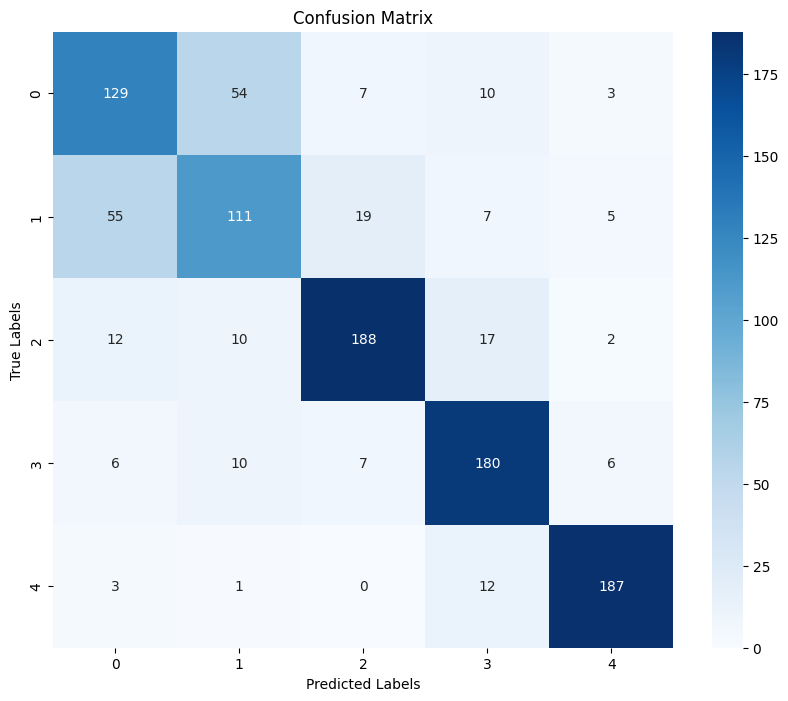

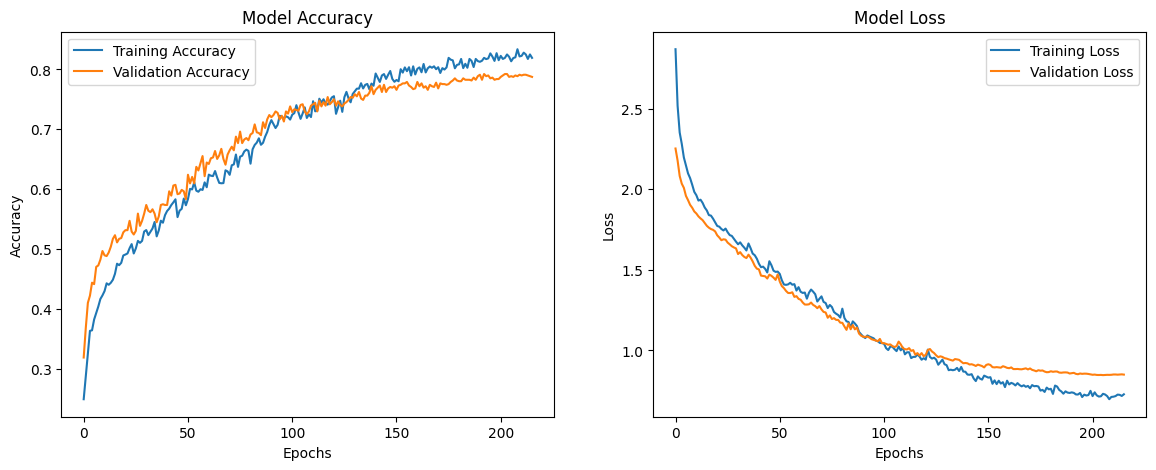

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPooling1D

# Load features and labels
time_features = np.load("./combined_features.npy")
y_labels_flat = np.load("./labels.npy")

# Balance classes using SMOTE
smote = SMOTE(random_state=42)
time_features_resampled, y_labels_resampled = smote.fit_resample(time_features, y_labels_flat)

# Normalize the features
scaler = StandardScaler()
time_features_normalized = scaler.fit_transform(time_features_resampled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    time_features_normalized, y_labels_resampled, test_size=0.2, random_state=42
)

# Convert labels to one-hot encoding for deep learning
num_classes = len(np.unique(y_labels_flat))
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Build the deep learning model
# ID CNN Model
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train_one_hot,
    epochs=500, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Deep Learning Model Accuracy: {accuracy:.2f}")

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Evaluate classification performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_labels_flat), yticklabels=np.unique(y_labels_flat))
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [27]:
# Save the model
model.save("pain_model.h5")
print("Model saved as cnn_model.h5")

# Save the scaler
import pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


Model saved as cnn_model.h5


In [6]:
import numpy as np
time_features = np.load("./combined_features.npy")

In [19]:
time_features[0]

array([ 2.93289522e-01,  2.42865596e+01,  5.89836975e+02, -5.32095700e+01,
        3.56340900e+01,  8.88436600e+01, -1.82892083e+01,  9.02325932e+00,
        2.01025846e+01, -6.15546513e-01, -9.10772120e-01,  2.18819197e+00,
        7.33223805e+02,  2.42883304e+01,  2.10070080e+01, -1.94471869e-03,
        1.44806861e+00, -1.13477800e+01,  2.33311863e+01,  8.78724930e-01,
        5.45011238e+00,  5.44538948e-02,  2.96522666e-03,  5.36893700e+00,
        5.58529900e+00,  2.16362000e-01,  5.41598361e+00,  5.44433812e+00,
        5.45343400e+00,  9.76987972e-01,  4.21296009e-01,  1.91159736e+00,
        1.36252810e+04,  5.45038441e+00,  5.45011238e+00, -7.85241674e-06,
        3.17583600e-04, -5.97450000e-04,  1.08329231e-03,  2.09701156e-04,
       -1.65616455e-01,  2.14628170e+00,  4.60652514e+00, -2.83966064e+00,
        4.03137207e+00,  6.87103271e+00, -2.10800171e+00, -8.61358643e-01,
        1.82228088e+00,  4.99239531e-01, -1.20379722e+00,  2.17622453e+00,
       -4.14041138e+02,  